In [ ]:
import requests
import pandas as pd
import glob
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

## Adding API Key


In [16]:
API_KEY = "472a988c6977caf40b323e4269c6b6db"

## Adding Time Period


In [8]:
start = datetime(2005, 1, 1)
end = datetime(2024, 12, 31)

## Adding Base URL

In [9]:
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"

## Adding Indicators for our Macro Data that we will fetch from fred API

In [10]:
INDICATORS = {
    "GDP":"GDPC1",
    "Inflation" : "CPIAUCSL",
    "Unemployment Rate":"UNRATE"
}

## Downloading S&P500 Data from yfinance

In [11]:
sp500 = yf.download('^GSPC', start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5032 entries, 2005-01-03 to 2024-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   5032 non-null   float64
 1   (High, ^GSPC)    5032 non-null   float64
 2   (Low, ^GSPC)     5032 non-null   float64
 3   (Open, ^GSPC)    5032 non-null   float64
 4   (Volume, ^GSPC)  5032 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.9 KB


## Function to fetch the fred API data

In [13]:
def fetch_fred_data(series_id):
    params = {
        'series_id' : series_id,
        'api_key': API_KEY,
        'file_type':'json',
        'observation_start':"2005-01-01",
        'observation_end':"2024-12-31"
    }
    response = requests.get(BASE_URL,params=params)
    if response.status_code != 200:
        print(f"Error fetching data for {series_id}:{response.status_code} - {response.text}")
        return pd.DataFrame()
    
    try:
        data = response.json()
        if 'observations' in data and isinstance(data["observations"],list):
            df = pd.DataFrame([(obs['date'],float(obs["value"])) for obs in data["observations"]],columns=["Date",'value'])
            df['Date'] = pd.to_datetime(df["Date"])
            df.set_index("Date",inplace=True)
            df = df.resample("M").mean().ffill()
            return df
    except Exception as e:
        print(f"Failed to parse JSON for {series_id}:{e}")
    
    return pd.DataFrame()

## Function to merge all the files to generate a file containing all the macro data

In [14]:
def merge_csv_files(output_file = "whole_macro_data.csv"):
    csv_files = glob.glob("*.csv")
    merged_df = None

    for file in csv_files:
        df = pd.read_csv(file)

        df.columns = df.columns.str.strip().str.lower()
        if 'date' not in df.columns:
            print(f"Skipping {file} - no 'date' column found")
            continue

        df['date'] = pd.to_datetime(df['date'])

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df,df ,on='date', how='outer')

    if merged_df is not None:
        merged_df.sort_values(by='date',inplace=True)
        merged_df.to_csv(output_file,index=False)
        print(f"Merged data saved to {output_file}")
    else:
        print("No data merged. Please check your CSV files")


## This is the main function that performs both the above function

In [17]:
def doTask():
    for name, series_id in INDICATORS.items():
        df = fetch_fred_data(series_id)
        if not df.empty:
            df.rename(columns={"value": name}, inplace=True)
            file_name = f"{name.replace(' ', '_').lower()}_data.csv"
            df.to_csv(file_name)
            print(f"Data saved to {file_name}")
        else:
            print(f"No data found for {name}")

    merge_csv_files()

doTask()

/tmp/ipykernel_13658/32286057.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample("M").mean().ffill()


Data saved to gdp_data.csv


/tmp/ipykernel_13658/32286057.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample("M").mean().ffill()


Data saved to inflation_data.csv
Data saved to unemployment_rate_data.csv
Merged data saved to whole_macro_data.csv


/tmp/ipykernel_13658/32286057.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample("M").mean().ffill()


## Dropping other columns 
We are only considering Close column for this 

In [18]:
sp500 = sp500.drop(['High','Low','Open','Volume'],axis=1)

In [19]:
sp500.to_csv("sp500.csv")

# If divided in multiple scripts, the second script will start here

# Relevant modules should be imported here

## Reading both csv files to get the data

In [20]:
data = pd.read_csv('sp500.csv')
data.head()

,Date,Close
0,2005-01-03,1202.079956
1,2005-01-04,1188.050049
2,2005-01-05,1183.739990
3,2005-01-06,1187.890015
4,2005-01-07,1186.189941


In [21]:
macro_data = pd.read_csv("whole_macro_data.csv")
macro_data.head()

,date,unemployment rate,gdp,inflation
0,2005-01-31,5.3,15844.727,191.6
1,2005-02-28,5.4,15844.727,192.4
2,2005-03-31,5.2,15844.727,193.1
3,2005-04-30,5.2,15922.782,193.7
4,2005-05-31,5.1,15922.782,193.6


## Merging both the files with the help of Date column in both the files

In [22]:
data["Date"] = pd.to_datetime(data["Date"],utc=True)
macro_data["date"] = pd.to_datetime(macro_data['date'])

In [23]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month

macro_data['year'] = macro_data['date'].dt.year
macro_data['month'] = macro_data['date'].dt.month

In [24]:
merged_data = pd.merge(data,macro_data,on=['year','month'],how='left')
merged_data = merged_data.drop(['year', 'month'], axis=1)
merged_data.head()


,Date,Close,date,unemployment rate,gdp,inflation
0,2005-01-03 00:00:00+00:00,1202.079956,2005-01-31,5.3,15844.727,191.6
1,2005-01-04 00:00:00+00:00,1188.050049,2005-01-31,5.3,15844.727,191.6
2,2005-01-05 00:00:00+00:00,1183.739990,2005-01-31,5.3,15844.727,191.6
3,2005-01-06 00:00:00+00:00,1187.890015,2005-01-31,5.3,15844.727,191.6
4,2005-01-07 00:00:00+00:00,1186.189941,2005-01-31,5.3,15844.727,191.6


In [25]:
date_col = merged_data['Date']
merged_data = merged_data.drop(['Date','date'],axis=1)

## Since different columns are in different Units, We will use Standard Scaler to make our data suitable for further visualisation

In [26]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data)

merged_data= pd.DataFrame(scaled_data,index=merged_data.index, columns=merged_data.columns)

In [27]:
merged_data = pd.concat([date_col.reset_index(drop=True),merged_data.reset_index(drop=True)],axis=1)
merged_data.head()

,Date,Close,unemployment rate,gdp,inflation
0,2005-01-03 00:00:00+00:00,-0.902485,-0.243745,-1.364377,-1.573029
1,2005-01-04 00:00:00+00:00,-0.913483,-0.243745,-1.364377,-1.573029
2,2005-01-05 00:00:00+00:00,-0.916861,-0.243745,-1.364377,-1.573029
3,2005-01-06 00:00:00+00:00,-0.913608,-0.243745,-1.364377,-1.573029
4,2005-01-07 00:00:00+00:00,-0.914941,-0.243745,-1.364377,-1.573029


## Visuals

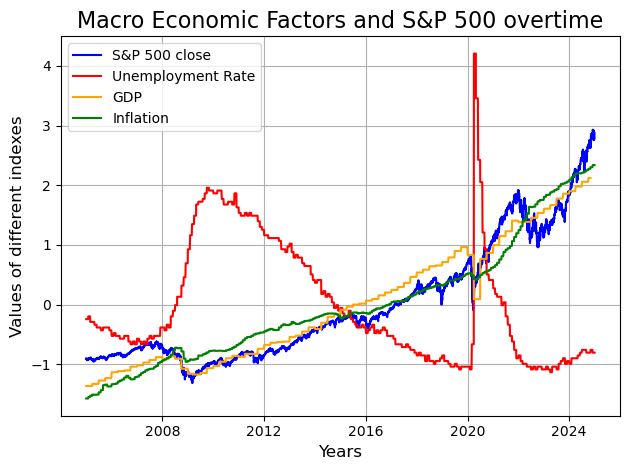

In [28]:
plt.plot(merged_data['Date'],merged_data['Close'],color='blue',label="S&P 500 close")
plt.plot(merged_data['Date'],merged_data['unemployment rate'],color='red',label="Unemployment Rate")
plt.plot(merged_data['Date'],merged_data['gdp'],color='orange',label="GDP")
plt.plot(merged_data['Date'],merged_data['inflation'],color='green',label="Inflation")
plt.title("Macro Economic Factors and S&P 500 overtime",fontsize=16)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Values of different indexes",fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

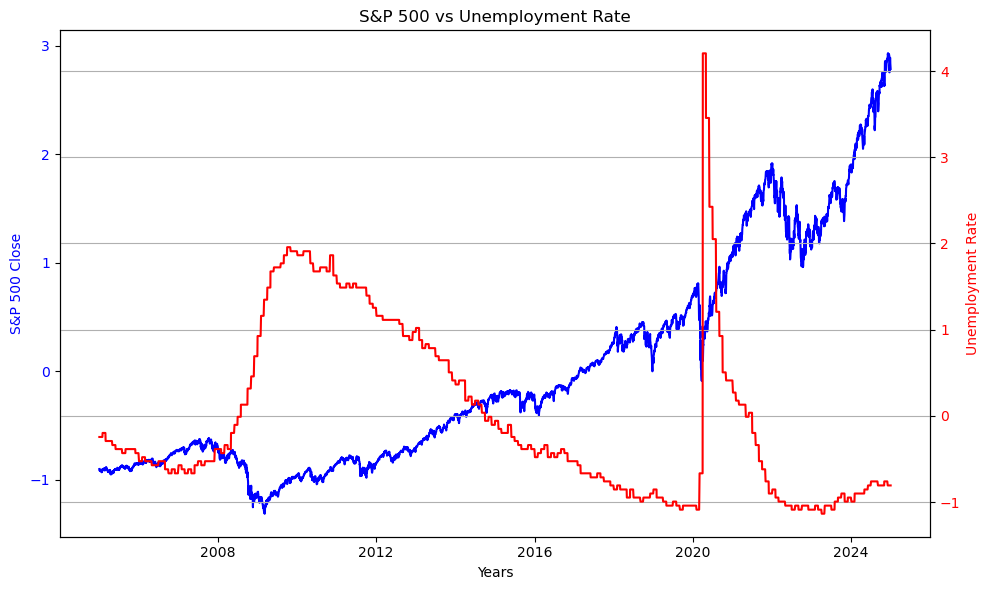

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Years')
ax1.set_ylabel('S&P 500 Close', color='blue')
ax1.plot(merged_data['Date'], merged_data['Close'], color='blue', label="S&P 500 Close")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Unemployment Rate', color='red')
ax2.plot(merged_data['Date'], merged_data['unemployment rate'], color='red', label="Unemployment Rate")
ax2.tick_params(axis='y', labelcolor='red')

plt.title('S&P 500 vs Unemployment Rate')
fig.tight_layout()
plt.grid(True)
plt.show()

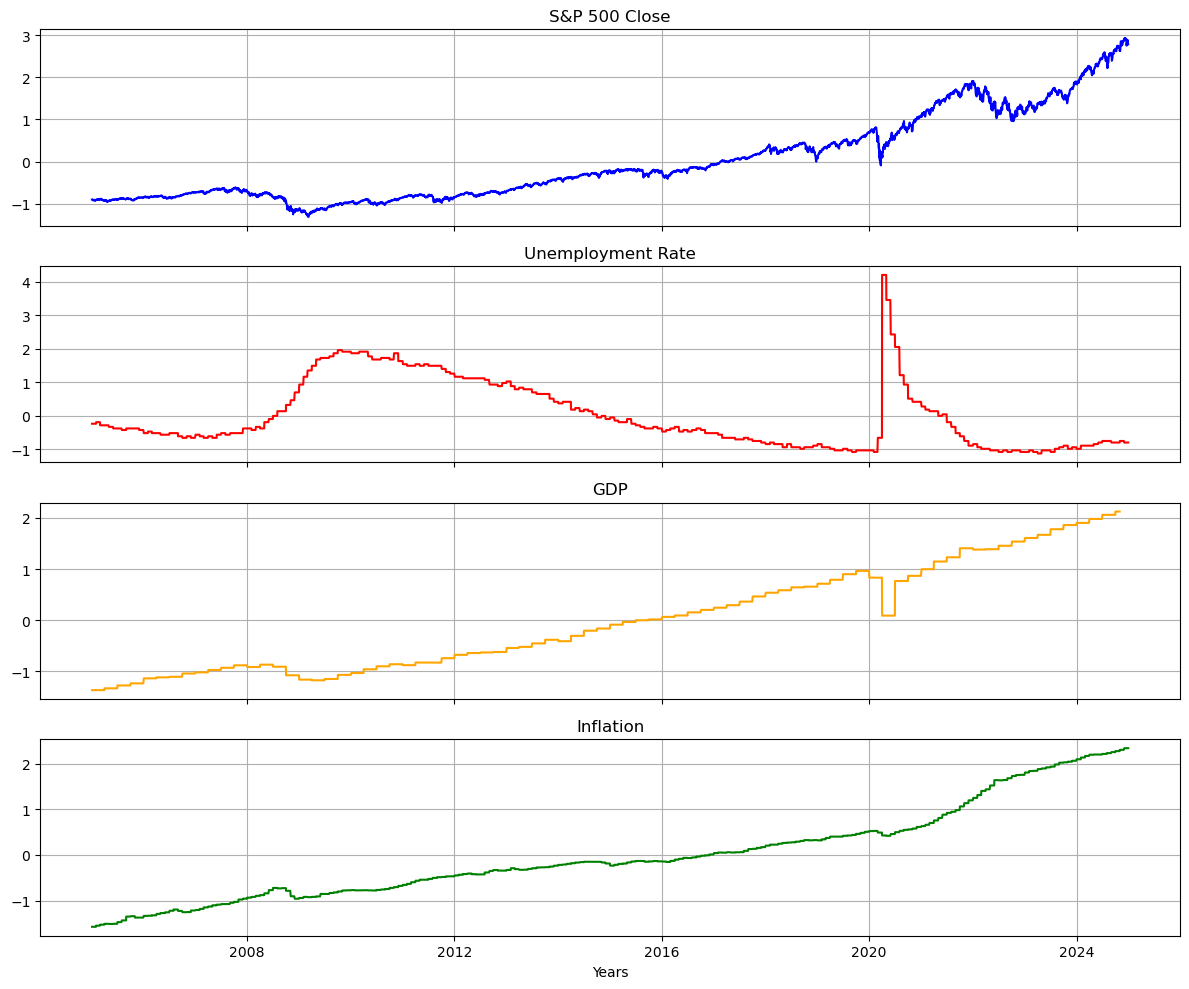

In [37]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(merged_data['Date'], merged_data['Close'], color='blue')
axs[0].set_title("S&P 500 Close")

axs[1].plot(merged_data['Date'], merged_data['unemployment rate'], color='red')
axs[1].set_title("Unemployment Rate")

axs[2].plot(merged_data['Date'], merged_data['gdp'], color='orange')
axs[2].set_title("GDP")

axs[3].plot(merged_data['Date'], merged_data['inflation'], color='green')
axs[3].set_title("Inflation")

for ax in axs:
    ax.grid(True)

plt.xlabel("Years")
plt.tight_layout()
plt.show()
